# This Model Ignored the specific machine failure categories TWF, HDF, PWF, OSF, RNF

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

#### Loading initial data

In [2]:
initial_data = pd.read_csv('../data/ai4i2020.csv')

#### Convering Type column into binary values for model preperation

In [3]:
dummy = pd.get_dummies(initial_data['Type'], dtype=int, drop_first=True)

In [4]:
cleaned_data = pd.concat([initial_data, dummy], axis=1)

In [5]:
cleaned_data.drop(columns=['Type'], inplace=True)

In [6]:
cleaned_data.head()

,UDI,Product ID,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,L,M
0,1,M14860,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,0,1
1,2,L47181,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,1,0
2,3,L47182,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,1,0
3,4,L47183,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,1,0
4,5,L47184,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,1,0


In [7]:
cleaned_data[["Machine failure", "L", "M", "Air temperature [K]",
              "Process temperature [K]", "Rotational speed [rpm]",
              "Torque [Nm]", "Tool wear [min]"]].corr()

,Machine failure,L,M,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
Machine failure,1.000000,0.035643,-0.022432,0.082556,0.035946,-0.044188,0.191321,0.105448
L,0.035643,1.000000,-0.801211,0.006676,0.005564,0.004735,0.001191,0.008232
M,-0.022432,-0.801211,1.000000,0.007958,0.005831,-0.004296,0.001991,-0.006976
Air temperature [K],0.082556,0.006676,0.007958,1.000000,0.876107,0.022670,-0.013778,0.013853
Process temperature [K],0.035946,0.005564,0.005831,0.876107,1.000000,0.019277,-0.014061,0.013488
Rotational speed [rpm],-0.044188,0.004735,-0.004296,0.022670,0.019277,1.000000,-0.875027,0.000223
Torque [Nm],0.191321,0.001191,0.001991,-0.013778,-0.014061,-0.875027,1.000000,-0.003093
Tool wear [min],0.105448,0.008232,-0.006976,0.013853,0.013488,0.000223,-0.003093,1.000000


#### Creating Logistic Regression Model

In [8]:
log_model = LogisticRegression(max_iter=1000)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = []
precision_scores = []
recall_scores = []

X = cleaned_data[["L", "M", "Air temperature [K]",
                  "Process temperature [K]", "Rotational speed [rpm]",
                  "Torque [Nm]", "Tool wear [min]"]]
y = cleaned_data["Machine failure"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
y_test.value_counts()

Machine failure
0    2428
1      72
Name: count, dtype: int64

#### Training Model

In [9]:
for train_set, val_set in kf.split(X_train):
    X_train_split, y_train_split = X_train.iloc[train_set], y_train.iloc[train_set]
    X_val_split, y_val_split = X_train.iloc[val_set], y_train.iloc[val_set]
    log_model.fit(X_train_split, y_train_split)
    model_predictions = log_model.predict(X_val_split)

    accuracy_scores.append(accuracy_score(y_val_split, model_predictions))
    precision_scores.append(precision_score(y_val_split, model_predictions))
    recall_scores.append(recall_score(y_val_split, model_predictions))

#### Assessing model's performance from splits

In [10]:
# The recall score is very low because the model is not able to predict the positive class
# This makes sense as their is a huge class imbalance in the data
print(f"Average Accuracy Scores: {np.mean(accuracy_scores) * 100}")
print(f"Average Precision Scores: {np.mean(precision_scores) * 100}")
print(f"Average Recall Scores: {np.mean(recall_scores) * 100}")

Average Accuracy Scores: 96.84000000000002
Average Precision Scores: 70.77564102564102
Average Recall Scores: 19.45721020966526


In [11]:
log_model.predict_proba(X_test)[:, 1]

array([0.01615824, 0.02230078, 0.0121622 , ..., 0.00463296, 0.01985425,
       0.01545302])

#### Using model

In [12]:
machine_telemtry = pd.DataFrame({
    "L": 1,
    "M": 0,
    "Air temperature [K]": 298.9,
    "Process temperature [K]": 309.1,
    "Rotational speed [rpm]": 2861,
    "Torque [Nm]": 4.6,
    "Tool wear [min]": 143
}, index=[0])

In [13]:
prediction = log_model.predict(machine_telemtry)
prediction

array([1])

In [14]:
log_model.coef_

array([[ 0.16068771, -0.09042323,  0.81885457, -0.90353228,  0.01129809,
         0.26706364,  0.01401553]])

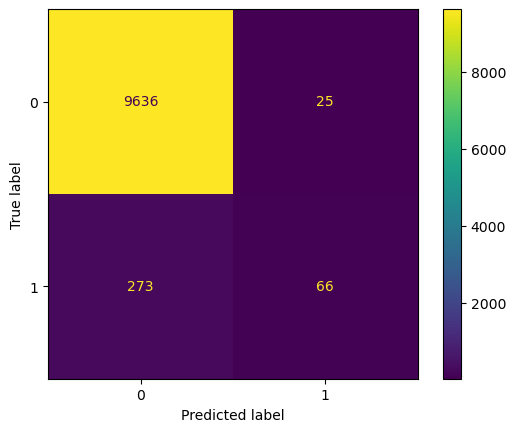

In [15]:
ConfusionMatrixDisplay.from_estimator(log_model, X, y)